## Machine Learning Final Project 

Student name: **Ruangrin Ldallitsakool**, Project 5: **Spam**

### Overview

The notebook is divided into the following parts:
* Problem Setting
* Data exploration and preprocessing
* Machine Learning Methods
    * Naive Bayes
    * Decision Tree and Random Forest
* Summary

## Problem Setting

This problem is a binary text classification problem that can be approached by supervised learning.

## Data

The dataset contains 57173 features (bag-of-words repesentation). The target is to classify $y \in {-1,+1}$ where $+1$ stands for spam, and $-1$ stands for not spam ("legitimate email").

## Problem Evaluation

The aim of the filter is to identify a maximum number of spam emails, with a maximum of 0.2% of all legitimate emails being classified incorrectly. As well,  a statement of  what percentage of incoming spam emails will be identified must be addressed. In addition, we are required to plot a precision/recall curve and mark the model's position using the model's threshold.

Using $y=1$ as positive (spam), we have that TP (True Positive) being the correct classification of spam, FP (False Positive) being legitimate emails being incorrectly classified as spams.

The model evaluation is as following:
* Low false positive rate (proportion of non-spam emails that are classified as spam), i.e. FP/(FP+TN) than $0.2$%
* High recall (Identifying a maximum number of spam emails), i.e. TP/(TP+FN)
* Accuracy maximization

### Importing packages

In [1]:
import numpy as np
import scipy.io
import gc 
import time
import random
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as met
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve
import matplotlib.pyplot as plt

### Importing Dataset

In [2]:
mat = scipy.io.loadmat('emails.mat')
X = mat['X'].toarray().T
y = mat['Y'].T

## Basic data exploration

Here we show some basic statistics regarding the data.
* All values in $X$ are nonnegative integers
* There are no missing values (NaN) in $X$ or $y$
* All elements in $y$ are -1 or +1
* All words occur at least once (that is, each column's sum is more than 0). Thus, we decide to not drop any columns.

In [3]:
print(f"Number of missing values in X: {np.isnan(X).sum()} | Y: {np.isnan(y).sum()}")
print(f"X shape: {X.shape}, Y shape: {y.shape}")
print(f"All words occur at least once: {np.all(X.sum(axis=0) > 0)}")
print(f"Type of labels: {np.unique(y)}")
print(f"Number of spam: {len(y[y==+1])} | Number of non spam: {len(y[y==-1])} | spam ratio: {round(100*len(y[y==+1]) / len(y))}% spam")

Number of missing values in X: 0 | Y: 0
X shape: (10000, 57173), Y shape: (10000, 1)
All words occur at least once: True
Type of labels: [-1  1]
Number of spam: 8030 | Number of non spam: 1970 | spam ratio: 80% spam


## Preprocessing and data split

We then split the data into training and testing data. Each dataset has similar spam-to-nonspam proportions, as the following cell.

**Important Note:**
due to the time and memory limits, I have chosen to train the model on 3000 random entries while I am fully aware that this is not the instructions I received for this project nor a real-life practice.

In [3]:
# Transform y from [-1,1] to [0,1]
y[y == -1] = 0

# Shuffle data
X,y = shuffle(X,y, random_state=1)

# Get Mini Dataset
X_mini, y_mini = X[:3000], y[:3000]

# Split Mini Dataset
X_train, X_test, y_train, y_test = train_test_split(X_mini, y_mini, test_size=0.20, random_state=1)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [4]:
print ('Propotion of dataset')

print(f"* All Data: Spam {len(y[y==+1])} ({round(len(y[y==+1])/len(y)*100)}%), not spam {len(y[y==0])}")
print(f"* Mini Data: Spam {len(y_mini[y_mini==+1])} ({round(len(y_mini[y_mini==+1])/len(y_mini)*100)}%), not spam {len(y_mini[y_mini==0])}")
print(f"* Train Data: Spam {len(y_train[y_train==+1])} ({round(len(y_train[y_train==+1])/len(y_train)*100)}%), not spam {len(y_train[y_train==0])}")
print(f"* Test Data: Spam {len(y_test[y_test==+1])} ({round(len(y_test[y_test==+1])/len(y_test)*100)}%), not spam {len(y_test[y_test==0])}")

Propotion of dataset
* All Data: Spam 8030 (80%), not spam 1970
* Mini Data: Spam 2420 (81%), not spam 580
* Train Data: Spam 1951 (81%), not spam 449
* Test Data: Spam 469 (78%), not spam 131


## Machine Learning Methods

In this project, we try different methods with the focus on the last one:
* Naive Bayes (as Baseline)
* Decision Tree
* Random Forest

In [5]:
def get_tp_rate(fn,tn):
    """
    This function calculates the false positive rate
    a.k.a the rate of mis-classifying legitinate emails as spam
    
    Input: int, int
    Output: float
    """
    return round(fn/(fn+tn),4)*100

def get_recall(tp,fn):
    """
    This function calculates the recall rate
    a.k.a the rate of detecting spam as spam
    
    Input: int, int
    Output: float
    """
    return round(tp/(tp+fn),4)*100


def train_test_summary(model, X_train, y_train, X_test, y_test, returning = False):
    """
    This function print the results of the given model and datasets: 
        - Training time (s)
        - Test accuracy (%)
        - Confusion Matrix (tp: int, fp: int, fn: int, tm:int)
        - Rate of misclassification in test data; false positive rate (%) 
        - whether the model passes the 0.2% misclassification criterion (bool)
        
    When returning is True, it also return the model with the test accuracy and false positive rate

    
    input: model, np.array, np.array, np.array, np.array, bool
    output (if True): model, float, float
    """
    
    # training
    start = time.time()
    model.fit(X_train, y_train.ravel())
    end = round(time.time()-start,4)
    
    # predict on training and testing sets given
    y_test_predict  = model.predict(X_test).ravel()
    tn, fp, fn, tp = met.confusion_matrix(y_test.ravel(), y_test_predict).ravel()    
    test_acc = round((tp+tn)*100/len(y_test),2)
    missclass = get_tp_rate(fn,tn)
    recall = get_recall(tp,fn)

    # print results
    print(f"{model = }")
    print(f"Training time: {end}s")
    print(f"Test Accuracy: {test_acc}%")
    print(f"Confusion matrix: {tp}, {fp}, {fn}, {tn}")
    print(f"Miss-classification of legitimate emails: {missclass}%")
    print(f"% of Spam Detected: {recall}%")
    print(f"Pass: {missclass<=0.20}")
    
    # return results
    if returning:
        return model, test_acc, missclass
    
    # delete model to perserve memory if not return
    else: del model; gc.collect()

In [6]:
def get_random_seed(n):
    randomlist = []
    for i in range(0,n):
        r = random.randint(1,1000)
        randomlist.append(r)
    return randomlist

def multiple_experiments(model, X, y, n):
    """
    This function splits train and test data using n random seeds.
    Then, the same model trains on those different splits to check if the model passed the criterion by chance.
    It returns the mean and std of the test accuracies and the false positive rates.
    """
    
    # get random seeds
    seeds = get_random_seed(n)
    
    test_acc_list = []
    missclass_list = []
    recall_list = []
    
    for seed in seeds:
        print (f"Seed no.: {seed}")
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed)
        _, test_acc, missclass = train_test_summary(model, X_train, y_train, X_test, y_test, returning = True)
        test_acc_list.append(test_acc)
        missclass_list.append(missclass)
    
    print(f"\nAverage accuracy: {np.mean(test_acc_list)}, std: {np.std(test_acc_list)}")
    print(f"Average false positive rate: {np.mean(missclass_list)}, std: {np.std(missclass_list)}")
    print(f"Average false positive rate: {np.mean(missclass_list)}, std: {np.std(missclass_list)}")
    
    print(f"This model passes the criterion: {np.mean(missclass_list)<=0.2}")
    
    return np.mean(test_acc_list), np.std(test_acc_list), np.mean(missclass_list), np.std(missclass_list)

### 1.1 NB (Baseline)

Naive Bayes is one of the most simplest and fastest algorithms for text classification. It assume that each feature is conditionally independent from one another. For each feature, it calculates the probability of such feature for each class.

In [15]:
train_test_summary(MultinomialNB(), X_train, y_train, X_test, y_test)

model = MultinomialNB()
Training time: 0.4189s
Test Accuracy: 97.83%
Confusion matrix: 471, 0, 13, 116
Miss-classification of legitimate emails: 10.08%
% of Spam Detected: 97.31%
Pass: False


### 1.2 Decision Tree
Decision Tree splits data into branches by using greedy strategy to find the best split, until every node purely consists of one class.

In [16]:
# Defalt-set Decision Tree
train_test_summary(DecisionTreeClassifier(), X_train, y_train, X_test, y_test)

# Experiments with 5x penalty toward legitimate emails classification
train_test_summary(DecisionTreeClassifier(class_weight={0: 5, 1: 1}), X_train, y_train, X_test, y_test)

# Experiments with 5x penalty toward spams classification
train_test_summary(DecisionTreeClassifier(class_weight={0: 1, 1: 5}), X_train, y_train, X_test, y_test)

model = DecisionTreeClassifier()
Training time: 21.2593s
Test Accuracy: 98.5%
Confusion matrix: 483, 8, 1, 108
Miss-classification of legitimate emails: 0.9199999999999999%
% of Spam Detected: 99.79%
Pass: False
model = DecisionTreeClassifier(class_weight={0: 5, 1: 1})
Training time: 8.8668s
Test Accuracy: 98.83%
Confusion matrix: 482, 5, 2, 111
Miss-classification of legitimate emails: 1.77%
% of Spam Detected: 99.59%
Pass: False
model = DecisionTreeClassifier(class_weight={0: 1, 1: 5})
Training time: 30.9889s
Test Accuracy: 98.83%
Confusion matrix: 481, 4, 3, 112
Miss-classification of legitimate emails: 2.6100000000000003%
% of Spam Detected: 99.38%
Pass: False


### Random Forest
Random Forest is the emsemble of decision trees, contructing different trees from sample repetitions

In [7]:
rf,_,_ = train_test_summary(RandomForestClassifier(), X_train, y_train, X_test, y_test, returning=True)

model = RandomForestClassifier()
Training time: 14.8179s
Test Accuracy: 99.5%
Confusion matrix: 469, 3, 0, 128
Miss-classification of legitimate emails: 0.0%
% of Spam Detected: 100.0%
Pass: True


In [8]:
# Train models on 10 different data-splits to make sure that the result above is not just a 'lucky' seed
mean_acc, std_acc, mean_missclass, std_missclass = multiple_experiments(rf, X_mini, y_mini, 10)

Seed no.: 653
model = RandomForestClassifier()
Training time: 13.228s
Test Accuracy: 99.17%
Confusion matrix: 488, 5, 0, 107
Miss-classification of legitimate emails: 0.0%
% of Spam Detected: 100.0%
Pass: True
Seed no.: 766
model = RandomForestClassifier()
Training time: 13.5778s
Test Accuracy: 98.83%
Confusion matrix: 479, 7, 0, 114
Miss-classification of legitimate emails: 0.0%
% of Spam Detected: 100.0%
Pass: True
Seed no.: 528
model = RandomForestClassifier()
Training time: 12.5967s
Test Accuracy: 99.0%
Confusion matrix: 481, 6, 0, 113
Miss-classification of legitimate emails: 0.0%
% of Spam Detected: 100.0%
Pass: True
Seed no.: 811
model = RandomForestClassifier()
Training time: 12.9895s
Test Accuracy: 99.67%
Confusion matrix: 491, 2, 0, 107
Miss-classification of legitimate emails: 0.0%
% of Spam Detected: 100.0%
Pass: True
Seed no.: 136
model = RandomForestClassifier()
Training time: 12.5385s
Test Accuracy: 99.67%
Confusion matrix: 485, 1, 1, 113
Miss-classification of legitimat

In [10]:
# Test on the whole dataset

y_test_predict = rf.predict(X[3000:])
tp, fp, fn, tn = met.confusion_matrix(y[3000:], y_test_predict).ravel()    
test_acc = round((tp+tn)*100/len(y_test_predict),2)
missclass = get_tp_rate(fn,tn)

print(f"Test Accuracy: {test_acc}%")
print(f"Confusion matrix: {tp}, {fp}, {fn}, {tn}")
print(f"Miss-classification of legitimate emails: {missclass}%")
print(f"Pass: {missclass<=0.20}")

Test Accuracy: 99.07%
Confusion matrix: 1336, 54, 11, 5599
Miss-classification of legitimate emails: 0.2%
Pass: True


#### RF Hyperparameter Exploring: No. of Trees

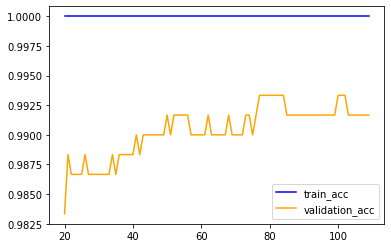

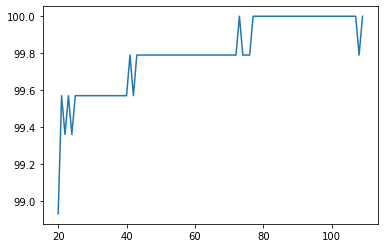

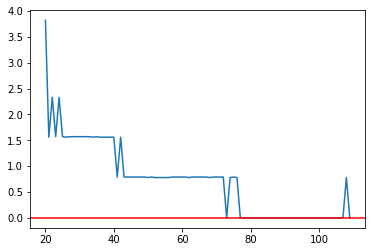

In [12]:
X_val,y_val = X_test,y_test.ravel()

params = [x for x in range(20,110)]

fitted_models = [RandomForestClassifier(n_estimators=int(x), random_state=1,).\
                 fit(X_train, y_train.ravel()) for x in params]

train_scores = np.array([model.score(X_train,y_train) for model in fitted_models])
test_scores = np.array([model.score(X_val,y_val) for model in fitted_models])

missclassifications = []
recalls = []

for model in fitted_models:
    tn, fp, fn, tp = met.confusion_matrix(y_val.ravel(), model.predict(X_val)).ravel()
    missclass = get_tp_rate(fn,tn)
    recall = get_recall(tp,fn)
    missclassifications.append(missclass)
    recalls.append(recall)
    
# Plotting Accuracy
fig, ax = plt.subplots()
ax.plot(params, train_scores, color="b", label="train_acc")
ax.plot(params, test_scores, color="orange", label="validation_acc")
ax.legend()

# Ploting Recall
fig, ax = plt.subplots()
ax.plot(params, recalls, label="recall")
    
# Ploting False Positive Rate
fig, ax = plt.subplots()
ax.plot(params, missclassifications, label="test_missclass")
plt.axhline(y=0.002, color='r', linestyle='-')

#### RF Hyperparameter Exploring: Maximum Tree Depth

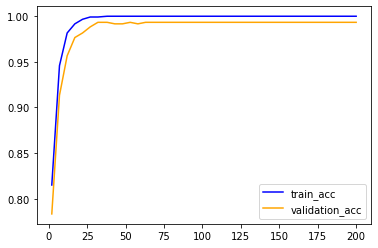

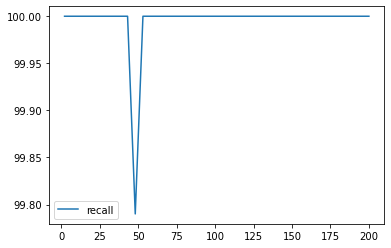

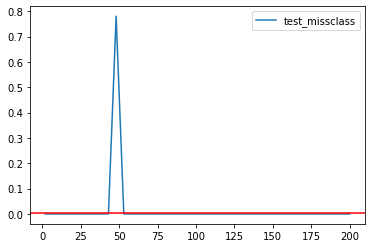

In [14]:
X_val,y_val = X_test,y_test.ravel()

params = [round(x) for x in np.linspace(start = 2, stop = 200, num = 40)]

fitted_models = [RandomForestClassifier(max_depth=int(x), random_state=1).\
                 fit(X_train, y_train.ravel()) for x in params]

train_scores = np.array([model.score(X_train,y_train) for model in fitted_models])
test_scores = np.array([model.score(X_val,y_val) for model in fitted_models])

missclassifications = []
recalls = []

for model in fitted_models:
    tn, fp, fn, tp = met.confusion_matrix(y_val.ravel(), model.predict(X_val)).ravel()
    missclass = get_tp_rate(fn,tn)
    recall = get_recall(tp,fn)
    missclassifications.append(missclass)
    recalls.append(recall)
    
# Plotting Accuracy
fig, ax = plt.subplots()
ax.plot(params, train_scores, color="b", label="train_acc")
ax.plot(params, test_scores, color="orange", label="validation_acc")
ax.legend()

# Ploting Recall
fig, ax = plt.subplots()
ax.plot(params, recalls, label="recall")
ax.legend()
    
# Ploting False Positive Rate
fig, ax = plt.subplots()
ax.plot(params, missclassifications, label="test_missclass")
plt.axhline(y=0.002, color='r', linestyle='-')
ax.legend()

### Adjusting the no. of trees and tree depth, according to the results above

In [15]:
rf_adjusted,_,_ = train_test_summary(RandomForestClassifier(n_estimators = 80 , max_depth=50), X_train, y_train, X_test, y_test, returning=True)

model = RandomForestClassifier(max_depth=50, n_estimators=80)
Training time: 10.6196s
Test Accuracy: 99.17%
Confusion matrix: 469, 5, 0, 126
Miss-classification of legitimate emails: 0.0%
% of Spam Detected: 100.0%
Pass: True


In [16]:
# Train models on 10 different data-splits to make sure that the result above is not just a 'lucky' seed
mean_acc, std_acc, mean_missclass, std_missclass = multiple_experiments(rf_adjusted, X_mini, y_mini, 10)

Seed no.: 924
model = RandomForestClassifier(max_depth=50, n_estimators=80)
Training time: 10.4635s
Test Accuracy: 99.67%
Confusion matrix: 509, 2, 0, 89
Miss-classification of legitimate emails: 0.0%
% of Spam Detected: 100.0%
Pass: True
Seed no.: 143
model = RandomForestClassifier(max_depth=50, n_estimators=80)
Training time: 11.3078s
Test Accuracy: 98.83%
Confusion matrix: 473, 7, 0, 120
Miss-classification of legitimate emails: 0.0%
% of Spam Detected: 100.0%
Pass: True
Seed no.: 107
model = RandomForestClassifier(max_depth=50, n_estimators=80)
Training time: 10.5514s
Test Accuracy: 99.5%
Confusion matrix: 482, 2, 1, 115
Miss-classification of legitimate emails: 0.86%
% of Spam Detected: 99.79%
Pass: False
Seed no.: 983
model = RandomForestClassifier(max_depth=50, n_estimators=80)
Training time: 10.7345s
Test Accuracy: 99.83%
Confusion matrix: 493, 0, 1, 106
Miss-classification of legitimate emails: 0.9299999999999999%
% of Spam Detected: 99.8%
Pass: False
Seed no.: 368
model = Ran

In [17]:
# Test on the whole dataset

y_test_predict = rf_adjusted.predict(X[3000:])
tp, fp, fn, tn = met.confusion_matrix(y[3000:], y_test_predict).ravel()    
test_acc = round((tp+tn)*100/len(y_test_predict),2)
missclass = get_tp_rate(fn,tn)

print(f"Test Accuracy: {test_acc}%")
print(f"Confusion matrix: {tp}, {fp}, {fn}, {tn}")
print(f"Miss-classification of legitimate emails: {missclass}%")
print(f"Pass: {missclass<=0.20}")

Test Accuracy: 99.31%
Confusion matrix: 1355, 35, 13, 5597
Miss-classification of legitimate emails: 0.22999999999999998%
Pass: False


## Ploting P/R Curve

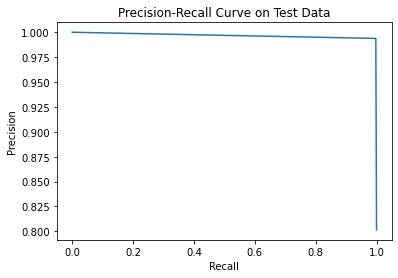

In [18]:
#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y[3000:], y_test_predict)

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision)

#add axis labels to plot
ax.set_title('Precision-Recall Curve on Test Data')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show()

# Summary

In this project, we explored the binary classification problem, targeting low falase positive rate, high recall rate, and high accuracy. Three models were used to appraoch the problem: NB, DT and RF. While the default-set RF Classifier in `sklearn.RandomForestClassifier` successfully coped with the problem. On 10 different seeds, its average accuracy reaches 99.31%, with False Positive rate of 0.17% and recall rate of 99.18%. 

We further explored that changes of two hyperparameters separately: number of trees and maximum tree depth. Then, a new model was constructed accoradingly. However, it did not match the performance of the original RF model.